<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/10K_300D_GLOVE_NN_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv 
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mental_health_data/full_mental_health_df.csv')

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 213186 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (150865, 500)


In [ ]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (150865, 11)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(135778, 500) (135778, 11)
(15087, 500) (15087, 11)


In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM,SpatialDropout1D,MaxPooling1D,Conv1D,Flatten,Dropout
from keras.models import Model

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-07-18 11:40:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-18 11:40:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-18 11:40:13--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


In [ ]:
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

#LSTM 100


In [ ]:

target_input = Input((500,), dtype='int32')

target_embedding = embeddingLayer(target_input)

lstm =LSTM(100,return_sequences=False)(target_embedding)

label= Dense(11,activation='softmax')(lstm)

model = Model(inputs=target_input, outputs=label) 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 500, 300)          120000300 
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 11)                1111      
Total params: 120,161,811
Trainable params: 161,511
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
266/266 [==============================] - 1423s 5s/step - loss: 1.6064 - accuracy: 0.4438 - val_loss: 0.9983 - val_accuracy: 0.6518
Epoch 2/10
266/266 [==============================] - 1431s 5s/step - loss: 0.9057 - accuracy: 0.6822 - val_loss: 0.8392 - val_accuracy: 0.7029
Epoch 3/10
266/266 [==============================] - 1426s 5s/step - loss: 0.7631 - accuracy: 0.7273 - val_loss: 0.7221 - val_accuracy: 0.7389
Epoch 4/10
266/266 [==============================] - 1448s 5s/step - loss: 0.6797 - accuracy: 0.7506 - val_loss: 0.6910 - val_accuracy: 0.7486
Epoch 5/10
266/266 [==============================] - 1459s 5s/step - loss: 0.6336 - accuracy: 0.7631 - val_loss: 0.6537 - val_accuracy: 0.7557
Epoch 6/10
266/266 [==============================] - 1394s 5s/step - loss: 0.5929 - accuracy: 0.7777 - val_loss: 0.6437 - val_accuracy: 0.7646
Epoch 7/10
266/266 [==============================] - 1360s 5s/step - loss: 0.5659 - accuracy: 0.7867 - val_loss: 0.6404 - val_accuracy:

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.8149
Testing Accuracy:  0.7810


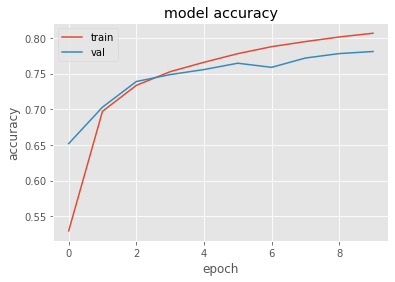

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]

3

In [ ]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[1630,   10,   12,  409,   20,   11,    5,    0,    1,   22,    3],
       [  14,   69,    5,   63,    6,    1,    1,    0,    3,    8,    2],
       [   5,    0,  667,   48,   12,    3,   10,    2,    1,    8,    7],
       [ 162,    8,   32, 4879,   51,    7,   21,    0,    7,  620,    2],
       [   7,    0,   19,   28, 1643,    5,    3,    1,    0,    2,    1],
       [  14,    0,   13,   40,   10,  435,    2,    0,    0,    1,    2],
       [  11,    1,   27,   58,   22,    1,  772,    5,    1,    4,    5],
       [   1,    0,    5,   12,   10,    0,    3,  120,    0,    1,    5],
       [  25,    3,   15,   90,    8,    0,    4,    0,  113,    1,    0],
       [  27,    3,   17, 1127,   10,    0,    3,    1,    3, 1349,    1],
       [   4,    0,   10,   14,    3,    3,    7,    1,    0,    2,  106]])

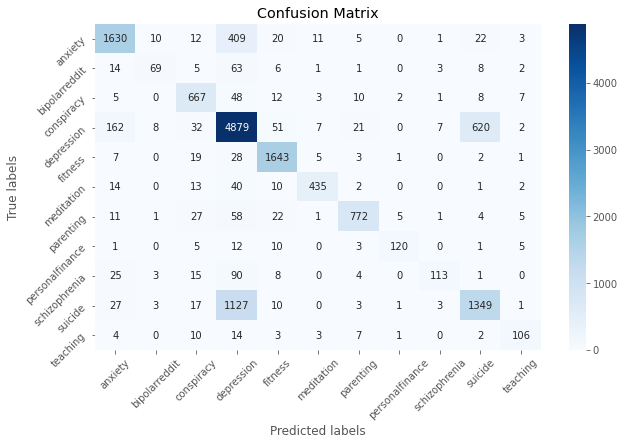

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#CNN


In [ ]:

target_input = Input((500,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(6,3,activation='relu')(target_embedding)

global_average=GlobalAveragePooling1DMasked()(convolution)

label= Dense(11,activation='softmax')(global_average)

model2 = Model(inputs=target_input, outputs=label) 
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 500, 300)          120000300 
_________________________________________________________________
conv1d (Conv1D)              (None, 498, 6)            5406      
_________________________________________________________________
global_average_pooling1d_mas (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                77        
Total params: 120,005,783
Trainable params: 5,483
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
history = model2.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
266/266 [==============================] - 269s 1s/step - loss: 2.1749 - accuracy: 0.2285 - val_loss: 1.8222 - val_accuracy: 0.3848
Epoch 2/10
266/266 [==============================] - 268s 1s/step - loss: 1.7514 - accuracy: 0.3982 - val_loss: 1.6295 - val_accuracy: 0.4270
Epoch 3/10
266/266 [==============================] - 267s 1s/step - loss: 1.5904 - accuracy: 0.4401 - val_loss: 1.5282 - val_accuracy: 0.4762
Epoch 4/10
266/266 [==============================] - 267s 1s/step - loss: 1.4913 - accuracy: 0.4843 - val_loss: 1.4532 - val_accuracy: 0.5019
Epoch 5/10
266/266 [==============================] - 267s 1s/step - loss: 1.4287 - accuracy: 0.5094 - val_loss: 1.3985 - val_accuracy: 0.5183
Epoch 6/10
266/266 [==============================] - 267s 1s/step - loss: 1.3746 - accuracy: 0.5257 - val_loss: 1.3582 - val_accuracy: 0.5274
Epoch 7/10
266/266 [==============================] - 267s 1s/step - loss: 1.3376 - accuracy: 0.5378 - val_loss: 1.3246 - val_accuracy: 0.5415

In [ ]:
loss, accuracy = model2.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5658
Testing Accuracy:  0.5638


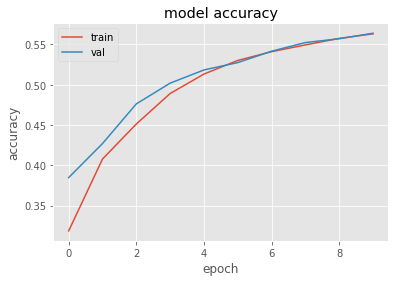

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions2 = model2.predict(X_test, batch_size=128, verbose=0)
rounded_predictions2=np.argmax(rounded_predictions2, axis=1)
rounded_predictions2[1]
rounded_labels2=np.argmax(Y_test, axis=1)
rounded_labels2[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm2 = confusion_matrix(rounded_labels2, rounded_predictions2)
cm2

array([[1148,    0,   13,  867,   65,    2,   25,    0,    0,    3,    0],
       [  10,    0,    3,  138,   14,    0,    6,    0,    0,    1,    0],
       [  11,    0,  232,  309,  161,    1,   47,    2,    0,    0,    0],
       [ 180,    0,    9, 5389,   91,    0,   64,    1,    0,   55,    0],
       [  13,    0,   31,  346, 1310,    0,    8,    1,    0,    0,    0],
       [  18,    0,   33,  294,   54,  109,    9,    0,    0,    0,    0],
       [  61,    0,   60,  499,   84,    1,  201,    1,    0,    0,    0],
       [   5,    0,   33,   47,   53,    0,   17,    2,    0,    0,    0],
       [  17,    0,    6,  198,   27,    1,   10,    0,    0,    0,    0],
       [  41,    0,    5, 2321,   42,    0,   17,    0,    0,  115,    0],
       [   3,    0,   20,   71,   39,    0,   17,    0,    0,    0,    0]])

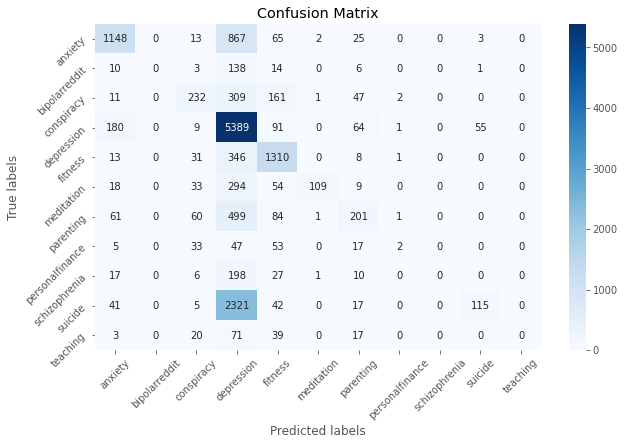

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm2, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#LSTM+CNN


In [ ]:
target_input = Input((500,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(6,3,activation='relu')(target_embedding)

lstm =LSTM(100,return_sequences=False)(convolution)

label= Dense(11,activation='softmax')(lstm)

model3 = Model(inputs=target_input, outputs=label) 
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 500, 300)          120000300 
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 498, 6)            5406      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               42800     
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1111      
Total params: 120,049,617
Trainable params: 49,317
Non-trainable params: 120,000,300
_________________________________________________________________


In [ ]:
history = model3.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
266/266 [==============================] - 1086s 4s/step - loss: 1.7672 - accuracy: 0.3955 - val_loss: 1.4174 - val_accuracy: 0.5128
Epoch 2/10
266/266 [==============================] - 1076s 4s/step - loss: 1.3674 - accuracy: 0.5224 - val_loss: 1.2480 - val_accuracy: 0.5656
Epoch 3/10
266/266 [==============================] - 1083s 4s/step - loss: 1.3597 - accuracy: 0.5250 - val_loss: 1.2277 - val_accuracy: 0.5662
Epoch 4/10
266/266 [==============================] - 1078s 4s/step - loss: 1.2203 - accuracy: 0.5715 - val_loss: 1.1280 - val_accuracy: 0.5994
Epoch 5/10
266/266 [==============================] - 1071s 4s/step - loss: 1.1044 - accuracy: 0.6091 - val_loss: 1.0736 - val_accuracy: 0.6228
Epoch 6/10
266/266 [==============================] - 1067s 4s/step - loss: 1.0568 - accuracy: 0.6261 - val_loss: 1.0492 - val_accuracy: 0.6372
Epoch 7/10
266/266 [==============================] - 1084s 4s/step - loss: 1.0218 - accuracy: 0.6431 - val_loss: 1.0147 - val_accuracy:

In [ ]:
loss, accuracy = model3.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6954
Testing Accuracy:  0.6919


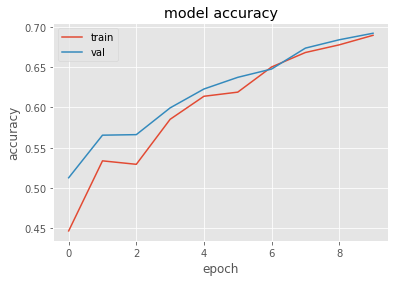

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions3 = model3.predict(X_test, batch_size=128, verbose=0)
rounded_predictions3=np.argmax(rounded_predictions3, axis=1)
rounded_predictions3[1]
rounded_labels3=np.argmax(Y_test, axis=1)
rounded_labels3[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm3 = confusion_matrix(rounded_labels3, rounded_predictions3)
cm3

array([[1546,    0,   12,  479,   32,    5,   18,    0,    0,   31,    0],
       [  11,    0,   12,  125,   12,    0,    7,    0,    0,    5,    0],
       [   2,    0,  555,  122,   42,    0,   29,    1,    0,   12,    0],
       [ 155,    0,   60, 4869,   52,    3,   51,    0,    0,  599,    0],
       [   8,    0,   77,  137, 1462,    3,   19,    0,    0,    3,    0],
       [  47,    0,   27,   79,   40,  316,    7,    0,    0,    1,    0],
       [  24,    0,   50,  175,   43,    1,  611,    1,    0,    2,    0],
       [   1,    0,   38,   17,   42,    0,   44,   15,    0,    0,    0],
       [  27,    0,   20,  163,   17,    1,   18,    0,    0,   13,    0],
       [  33,    0,   24, 1399,   12,    0,    9,    0,    0, 1064,    0],
       [   4,    0,   29,   38,   25,    0,   50,    3,    0,    1,    0]])

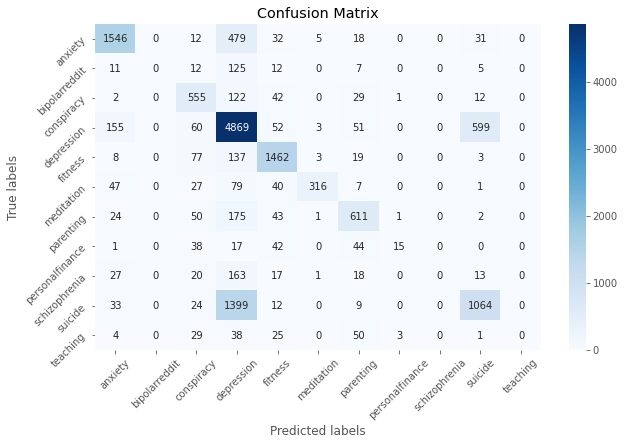

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);